In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from numpy.random import seed

import random
seed(20)  ##15 for left canal
random.seed(20)
import google.protobuf

import gast
import tensorflow as tf
#tf.random.set_seed(20) ##32 for training 1

from keras import backend as K
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.random.set_seed(20)

from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
tf.test.is_gpu_available()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11918347547566412531
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40074543104
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10863724997753895796
physical_device_desc: "device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0"
xla_global_id: 416903419
]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-08-24 17:11:36.212165: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 17:11:36.968171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 38218 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0
2023-08-24 17:11:36.980218: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 38218 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0


True

In [2]:
import cv2
import glob

from tqdm import tqdm
import skimage.io as io
import cv2
import skimage.transform as trans
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import SimpleITK as sitk
import nibabel as nib
from scipy import ndimage

def dice_coef(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.cast(tf.reshape(y_true,[-1]),tf.float32)
    y_pred_f =tf.cast(tf.reshape(y_pred,[-1]),tf.float32)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (1-(2. * intersection + smooth) / (union + smooth))

def compute_dice(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

def get_full_scan(folder_path):

    files_List  = glob.glob(folder_path + '/**/*.dcm', recursive = True)
    itkimage = sitk.ReadImage(files_List[0])
    rows = int(itkimage.GetMetaData('0028|0010'))
    cols = int(itkimage.GetMetaData('0028|0011'))
    
    a = itkimage.GetMetaData('0028|0030')
    c = itkimage.GetMetaData('0018|0050')
    #print('z spacing ',c)
    #print('xy spacing: ',a)
    mn = 1000
    mx = 0
    for file in (files_List):
        itkimage = sitk.ReadImage(file)
        mn = np.min([mn, int(itkimage.GetMetaData('0020|0013'))])
        mx = np.max([mx, int(itkimage.GetMetaData('0020|0013'))])
    full_scan = np.ndarray(shape=(mx-mn+1,rows,cols), dtype=float, order='F')
    for file in (files_List):
        img, n = dcm_image(file)
        n = int(n)
        full_scan[n-mn,:,:] = img[0,:,:]
    return full_scan

def dcm_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    ins = float(itkimage.GetMetaData('0020|0013'))
    return numpyImage, ins

import copy
def get_normalized(scann,mn,mx):
    scan = copy.copy(scann)
    mn = max(mn,np.amin(scan))
    mx = min(mx,np.amax(scan))
    np.clip(scan, mn, mx, out=scan)
    d = mx - mn
    scan = (scan-mn)/d
    return scan

def res_scan(nscan,image_size):

    depth_factor = image_size[0]/nscan.shape[0]
    width_factor = image_size[2]/nscan.shape[2]
    height_factor = image_size[1]/nscan.shape[1]
    nscann = copy.copy(nscan)
    nscann = ndimage.zoom(nscann, (depth_factor, height_factor, width_factor), order=1)
    return nscann

def res_mask(nmask,image_size):
    depth_factor = image_size[0]/nmask.shape[0]
    width_factor = image_size[2]/nmask.shape[2]
    height_factor = image_size[1]/nmask.shape[1]

    nmaskk = copy.copy(nmask)
    nmaskk = ndimage.zoom(nmaskk, (depth_factor, height_factor, width_factor), order=1, mode = 'nearest')
    return nmaskk

def random_crop_3d_samples(image_volume, mask_volume, crop_size, num_samples=4, pos=1,neg=1):
    # Convert the image and mask volumes to TensorFlow tensors
#     image_volume = tf.constant(image_volume, dtype=tf.float32)
#     mask_volume = tf.constant(mask_volume, dtype=tf.float32)

    depth, height, width = image_volume.shape

    # Create an empty list to store the cropped samples
    cropped_samples_i = []
    cropped_samples_m = []

    # Calculate the positive and negative sample counts based on the ratio
    num_pos_samples = int(num_samples * (pos/(pos+neg)))
    num_neg_samples = num_samples - num_pos_samples
    p =  np.random.randint(0, 40)
    

    for _ in range(num_pos_samples):
        # Randomly choose a foreground voxel as the center of the crop
        pos_indices = tf.where(mask_volume > 0)
        rand_index = tf.random.uniform(shape=(1,), maxval=pos_indices.shape[0], dtype=tf.int64)
        center_coords = pos_indices[rand_index[0], :]

        # Calculate the starting point of the crop based on the center
        start_depth = max(center_coords[0] - crop_size[0] // 2, 0)
        start_height = max(center_coords[1] - crop_size[1] // 2, 0)
        start_width = max(center_coords[2] - crop_size[2] // 2, 0)

        # Adjust the starting point to avoid out-of-bounds cropping
        start_depth = min(start_depth, depth - crop_size[0])
        start_height = min(start_height, height - crop_size[1])
        start_width = min(start_width, width - crop_size[2])

        # Crop the image and mask volumes
        cropped_image = image_volume[start_depth:start_depth + crop_size[0],
                                     start_height:start_height + crop_size[1],
                                     start_width:start_width + crop_size[2]]

        cropped_mask = mask_volume[start_depth:start_depth + crop_size[0],
                                   start_height:start_height + crop_size[1],
                                   start_width:start_width + crop_size[2]]

        cropped_samples_i.append(cropped_image)
        cropped_samples_m.append(cropped_mask)

    for _ in range(num_neg_samples):
        # Randomly choose a background voxel as the center of the crop
        neg_indices = tf.where(mask_volume == 0)
        rand_index = tf.random.uniform(shape=(1,), maxval=neg_indices.shape[0], dtype=tf.int64)
        center_coords = neg_indices[rand_index[0], :]

        # Calculate the starting point of the crop based on the center
        start_depth = max(center_coords[0] - crop_size[0] // 2, 0)
        start_height = max(center_coords[1] - crop_size[1] // 2, 0)
        start_width = max(center_coords[2] - crop_size[2] // 2, 0)

        # Adjust the starting point to avoid out-of-bounds cropping
        start_depth = min(start_depth, depth - crop_size[0])
        start_height = min(start_height, height - crop_size[1])
        start_width = min(start_width, width - crop_size[2])

        # Crop the image and mask volumes
        cropped_image = image_volume[start_depth:start_depth + crop_size[0],
                                     start_height:start_height + crop_size[1],
                                     start_width:start_width + crop_size[2]]

        cropped_mask = mask_volume[start_depth:start_depth + crop_size[0],
                                   start_height:start_height + crop_size[1],
                                   start_width:start_width + crop_size[2]]

        cropped_samples_i.append(cropped_image)
        cropped_samples_m.append(cropped_mask)
    random.Random(p).shuffle(cropped_samples_i)
    random.Random(p).shuffle(cropped_samples_m)
    cropped_samples_i = np.array(cropped_samples_i)
    cropped_samples_m = np.array(cropped_samples_m)
    
    return cropped_samples_i, cropped_samples_m

# Example usage:
# Assuming 'image_volume' and 'mask_volume' are 3D NumPy arrays representing the MRI volume and mask volume
# crops = random_crop_3d_samples(image_volume, mask_volume, crop_size=(96, 96, 96), num_samples=10, pos_to_neg_ratio=0.5)
# crops is a list of tuples, each containing a cropped image and its respective mask

def crop_3d_samples(test_volume, test_mask, crop_size=(96, 96, 96)):
    """
    Crop non-overlapping samples from a 3D test volume and its corresponding mask, and pad the edge volumes to become equal to the crop size.

    Parameters:
        test_volume (numpy.ndarray): The 3D test volume (numpy array).
        test_mask (numpy.ndarray): The 3D mask volume for the test volume (numpy array).
        crop_size (tuple): The size of the crop (depth, height, width).

    Returns:
        list, list: Two lists containing the cropped non-overlapping samples for the volume and mask, respectively.
    """
    # Check the input test volume, test mask, and crop size
    if not isinstance(test_volume, np.ndarray) or len(test_volume.shape) != 3:
        raise ValueError("Test volume must be a 3D numpy array.")

    if not isinstance(test_mask, np.ndarray) or len(test_mask.shape) != 3:
        raise ValueError("Test mask must be a 3D numpy array.")

    if not isinstance(crop_size, tuple) or len(crop_size) != 3:
        raise ValueError("Crop size must be a tuple of length 3 (depth, height, width).")

    # Get the shape of the test volume
    depth, height, width = test_volume.shape

    # Calculate the number of crops along each axis
    num_crops_depth = (depth) // crop_size[0]
    num_crops_height = (height) // crop_size[1]
    num_crops_width = (width) // crop_size[2]
    print(num_crops_depth,num_crops_height,num_crops_width)
    # Calculate the amount of padding needed for each dimension
    pad_depth = crop_size[0] - (depth -  num_crops_depth * crop_size[0])
    pad_height = crop_size[1] - (height -  num_crops_height * crop_size[1])
    pad_width = crop_size[2] - (width - num_crops_width * crop_size[2] )
    print(pad_depth,pad_height,pad_width)
    num_crops_depth = num_crops_depth + 1 if pad_depth > 0 else num_crops_depth
    num_crops_height = num_crops_height + 1 if pad_height > 0 else num_crops_height
    num_crops_width = num_crops_width + 1 if pad_width > 0 else num_crops_width
    print(num_crops_depth,num_crops_height,num_crops_width)
    # Pad the test volume and test mask to match the crop size
    padded_volume = np.pad(test_volume, ((0, pad_depth), (0, pad_height), (0, pad_width)), mode='constant')
    padded_mask = np.pad(test_mask, ((0, pad_depth), (0, pad_height), (0, pad_width)), mode='constant')
    print(padded_volume.shape,padded_mask.shape)
    plt.figure()
    plt.imshow(padded_volume[:,:,150])
    plt.figure()
    plt.imshow(padded_mask[:,:,150])
    plt.figure()
    plt.imshow(padded_volume[:,:,125])
    plt.figure()
    plt.imshow(padded_mask[:,:,125])
    plt.figure()
    plt.imshow(padded_volume[:,:,125],alpha=0.5)
    plt.imshow(padded_mask[:,:,125])
    # Initialize lists to store the cropped samples for the volume and mask
    cropped_volume_samples = []
    cropped_mask_samples = []

    # Iterate through the 3D volume and crop non-overlapping samples
    for d in range(num_crops_depth):
        for h in range(num_crops_height):
            for w in range(num_crops_width):
                # Calculate the starting and ending indices for cropping
                start_depth = d * crop_size[0]
                end_depth = (d + 1) * crop_size[0]
                start_height = h * crop_size[1]
                end_height = (h + 1) * crop_size[1]
                start_width = w * crop_size[2]
                end_width = (w + 1) * crop_size[2]

                # Crop the sub-volumes for the volume and mask
                cropped_sub_volume = padded_volume[start_depth:end_depth, start_height:end_height, start_width:end_width]
                cropped_sub_mask = padded_mask[start_depth:end_depth, start_height:end_height, start_width:end_width]

                # Append the cropped sub-volumes to the lists
                cropped_volume_samples.append(cropped_sub_volume)
                cropped_mask_samples.append(cropped_sub_mask)

    cropped_volume_samples = np.array(cropped_volume_samples)
    cropped_mask_samples = np.array(cropped_mask_samples)
    return cropped_volume_samples, cropped_mask_samples,padded_volume,padded_mask

# Example usage:
# Assuming you have a 3D test volume 'test_volume' and its corresponding mask 'test_mask',
# and you want to crop non-overlapping samples of size (96, 96, 96).
# cropped_volume_samples, cropped_mask_samples = crop_non_overlapping_samples(test_volume, test_mask, crop_size=(96, 96, 96))
# Now you can pass each cropped sample through the U-Net model for prediction and calculate the Dice score.

In [3]:
imgpath = sorted(glob.glob(r"/home/rabeea/Task09_Spleen/imagesTr/*.gz", recursive = True))
maskpath = sorted(glob.glob(r"/home/rabeea/Task09_Spleen/labelsTr/*.gz", recursive = True))
tr = 28
val = 5
ts = 8
random.Random(42).shuffle(imgpath)
random.Random(42).shuffle(maskpath)
trainpath = imgpath[:tr]
trainpath_m = maskpath[:tr]
valpath = imgpath[tr:tr+val]
valpath_m = maskpath[tr:tr+val]
testpath = imgpath[tr+val:]
testpath_m = maskpath[tr+val:]
print(len(imgpath), len(trainpath), len(valpath), len(testpath))
print(valpath[:3],valpath_m[:3])

41 28 5 8
['/home/rabeea/Task09_Spleen/imagesTr/spleen_13.nii.gz', '/home/rabeea/Task09_Spleen/imagesTr/spleen_10.nii.gz', '/home/rabeea/Task09_Spleen/imagesTr/spleen_63.nii.gz'] ['/home/rabeea/Task09_Spleen/labelsTr/spleen_13.nii.gz', '/home/rabeea/Task09_Spleen/labelsTr/spleen_10.nii.gz', '/home/rabeea/Task09_Spleen/labelsTr/spleen_63.nii.gz']


In [4]:
from tensorflow.keras.utils import Sequence


def parse_image(img_path):
    imgg = nib.load(img_path)
    img = imgg.get_fdata()
    #print('image size: ',img.shape)
    x, y, z = imgg.header.get_zooms()
    #print('x, y, z: ',x, y, z)
    new_x = int(x*img.shape[0])
    new_y = int(y*img.shape[1])
    new_z = int(z*img.shape[2])
    image_size = (new_x,new_y,new_z)
    #print('newsize: ',image_size)
    img = res_scan(img, image_size)
    img = get_normalized(img,-57,164)
    
#     mn = np.amin(img)
#     mx = np.amax(img)
#     d = mx - mn
#     img = (img-mn)/d
    #img = np.expand_dims(img, axis=3)
    #train_img = np.stack((image_rgb,)*3, axis=-1)
    
    return img, image_size

def parse_mask(mask_path, image_size):
    mask = nib.load(mask_path)
    mask = mask.get_fdata()
    #mask = np.swapaxes(mask,0,2)
    mask = res_mask(mask, image_size)
    #mask = np.expand_dims(mask, axis=3)
    
    mask = np.where(mask>0,1,mask)
    mask = mask.astype(np.uint8)
    return mask

class DataGen(Sequence):
    def __init__(self, image_size, images_path,mask_path, batch_size=1,num_samples=4, pos_to_neg_ratio=1 ,mode = 'train'):
        self.image_size = image_size
        self.images_path = images_path
        self.mask_path = mask_path
        self.num_samples = num_samples
        self.pos_to_neg_ratio = pos_to_neg_ratio
        self.batch_size = batch_size
        self.mode = mode
        self.on_epoch_end()

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.images_path):
            self.batch_size = len(self.images_path) - index*self.batch_size

        images_path = self.images_path[index*self.batch_size : (index+1)*self.batch_size]
        mask_path = self.mask_path[index*self.batch_size : (index+1)*self.batch_size]
        for i in range(len(images_path)):
            # Read image and mask
            #print(images_path[i],mask_path[i])
            image,img_size = parse_image(images_path[i])
            mask = parse_mask(mask_path[i], img_size)
            image, mask = random_crop_3d_samples(image, mask, self.image_size, self.num_samples, self.pos_to_neg_ratio)
#             if self.mode =='train':
#                 image, mask = random_crop_3d_samples(imagee, maskk, self.image_size, self.num_samples, self.pos_to_neg_ratio)
#             else:
            
#                 image, mask= crop_3d_samples(imagee, maskk, self.image_size)
                    
            image  = np.expand_dims(image, axis=4)
            mask = np.expand_dims(mask, axis=4)
            mask = np.where(mask>0,1,mask)
            mask = mask.astype(np.uint8)

        #return np.array(images_batch), np.array(masks_batch)
        return image,mask#,imagee,maskk#, aim, amas

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.images_path)/(float(self.batch_size))))
    

In [5]:
image_size = (96,96,96)
batch_size = 1
num_samples=4
pos_to_neg_ratio=1
epochs = 350

train_steps = len(trainpath)//batch_size
valid_steps = len(valpath)//batch_size

## Generator
train_gen = DataGen(image_size, trainpath,trainpath_m,batch_size=batch_size,num_samples=4, pos_to_neg_ratio=1)
valid_gen = DataGen(image_size,valpath, valpath_m, batch_size=batch_size,num_samples=4, pos_to_neg_ratio=1 )
#test_gen = DataGen(image_size,testpath, testpath_m, batch_size=1,mode = 'test')

In [6]:
t,p = train_gen.__getitem__(1)


2023-07-24 11:53:00.030387: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78933 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:b1:00.0, compute capability: 8.0


In [8]:
t.shape

(4, 96, 96, 96, 1)

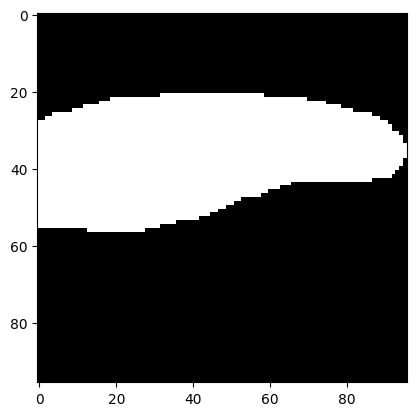

In [9]:
plt.imshow(p[2,:,:,45,0],'gray')

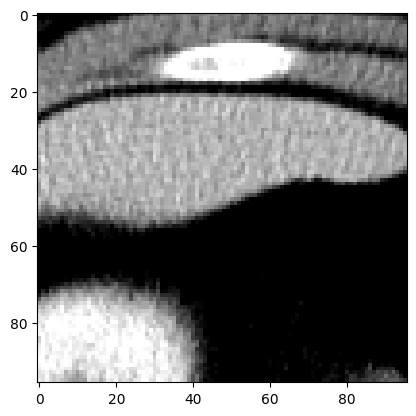

In [10]:
plt.imshow(t[2,:,:,45,0],'gray')

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import tensorflow as tf

def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=4),
                          arguments={'repnum': rep})(tensor)

def conv_block(x, size, dropout):
    # Convolutional layer.
    conv = layers.Conv3D(size, (3, 3, 3),activation = 'relu', padding = 'same')(x)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv3D(size, (3, 3, 3),activation = 'relu', padding = 'same')(conv)
    conv = layers.BatchNormalization()(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    return conv
def gating_signal(input, out_size):
    # resize the down layer feature map into the same dimension as the up layer feature map
    # using 1x1 conv
    # :return: the gating feature map with the same dimension of the up layer feature map
    x = layers.Conv3D(out_size, (1, 1, 1), kernel_initializer='he_uniform', padding='same')(input)
    x = layers.Activation('relu')(x)
    return x
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)  # (None, 8, 8, 8, 128)
    shape_g = K.int_shape(gating)  # (None, 4, 4, 4, 128)
    # Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv3D(inter_shape, (2, 2, 2), strides=(2, 2, 2), kernel_initializer='he_uniform', padding='same')(
        x)  # 16
    shape_theta_x = K.int_shape(theta_x)
    # Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv3D(inter_shape, (1, 1, 1), kernel_initializer='he_uniform', padding='same')(gating)
    upsample_g = layers.Conv3DTranspose(inter_shape, (3, 3, 3),
                                        strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2],
                                                 shape_theta_x[3] // shape_g[3]),
                                        kernel_initializer='he_uniform', padding='same')(phi_g)  # 16
    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv3D(1, (1, 1, 1), kernel_initializer='he_uniform', padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling3D(
        size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2], shape_x[3] // shape_sigmoid[3]))(
        sigmoid_xg)  # 32
    #print(upsample_psi.shape,shape_x[3])
    #upsample_psi = expend_as(upsample_psi, shape_x[3])
    upsample_psi = repeat_elem(upsample_psi, shape_x[4])
    y = layers.multiply([upsample_psi, x])
    result = layers.Conv3D(shape_x[4], (1, 1, 1), kernel_initializer='he_uniform', padding='same')(y)
    return result

def Attention_UNet_3D_Model(input_shape):
    # network structure
    filter_numb = 16  # number of filters for the first layer
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_64 = conv_block(inputs, filter_numb, dropout=0)
    pool_32 = layers.MaxPooling3D((2, 2, 2), padding="same")(conv_64)
    # DownRes 2
    conv_32 = conv_block(pool_32, 2 * filter_numb, dropout=0)
    pool_16 = layers.MaxPooling3D((2, 2, 2), padding="same")(conv_32)
    # DownRes 3
    conv_16 = conv_block(pool_16, 3 * filter_numb, dropout=0)
    pool_8 = layers.MaxPooling3D((2, 2, 2), padding="same")(conv_16)
    # DownRes 4
    conv_8 = conv_block(pool_8, 4 * filter_numb, dropout=0.01)
    pool_4 = layers.MaxPooling3D((2, 2, 2), padding="same")(conv_8)
    # DownRes 5, convolution only

    conv_4 = conv_block(pool_4, 5 * filter_numb, dropout=0.01)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_8 = gating_signal(conv_4, 4 * filter_numb)
    att_8 = attention_block(conv_8, gating_8, 4 * filter_numb)
    up_8 = layers.UpSampling3D((2, 2, 2), data_format="channels_last")(conv_4)
    up_8 = layers.concatenate([up_8, att_8])
    up_conv_8 = conv_block(up_8, 4 * filter_numb, dropout=0)
    # UpRes 7
    gating_16 = gating_signal(up_conv_8, 3 * filter_numb)
    att_16 = attention_block(conv_16, gating_16, 3 * filter_numb)
    up_16 = layers.UpSampling3D((2, 2, 2), data_format="channels_last")(up_conv_8)
    up_16 = layers.concatenate([up_16, att_16])
    up_conv_16 = conv_block(up_16, 3 * filter_numb, dropout=0)
    # UpRes 8
    gating_32 = gating_signal(up_conv_16, 2 * filter_numb)
    att_32 = attention_block(conv_32, gating_32, 2 * filter_numb)
    up_32 = layers.UpSampling3D((2, 2, 2), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32])
    up_conv_32 = conv_block(up_32, 2 * filter_numb, dropout=0)
    # UpRes 9
    gating_64 = gating_signal(up_conv_32, filter_numb)
    att_64 = attention_block(conv_64, gating_64, filter_numb)
    up_64 = layers.UpSampling3D(size=(2, 2, 2), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64])
    up_conv_64 = conv_block(up_64, filter_numb, dropout=0)

    # final convolutional layer
    conv_final = layers.Conv3D(1, 1, activation = 'sigmoid')(up_conv_64)

    model = Model(inputs=[inputs], outputs=[conv_final], name="Attention_UNet_3D_Model")
    model.compile(optimizer = Adam(lr = 1e-4), loss = dice_loss, metrics = [dice_coef])
    model.summary()
    return model

In [4]:
a= Attention_UNet_3D_Model((96,96,96,1))

2023-08-24 17:12:06.347159: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38218 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0


Model: "Attention_UNet_3D_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 96,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 96, 96, 96,   448         ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 96, 96, 96,   64         ['conv3d[0][0]']                 
 alization)                     16)                                         

/home/rabeea/anaconda3/envs/beea/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 rmalization)                                                                                     
                                                                                                  
 dropout_1 (Dropout)            (None, 6, 6, 6, 80)  0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv3d_10 (Conv3D)             (None, 6, 6, 6, 64)  5184        ['dropout_1[0][0]']              
                                                                                                  
 activation (Activation)        (None, 6, 6, 6, 64)  0           ['conv3d_10[0][0]']              
                                                                                                  
 conv3d_12 (Conv3D)             (None, 6, 6, 6, 64)  4160        ['activation[0][0]']             
                                                                                                  
 conv3d_tr

                                                                                                  
 lambda_1 (Lambda)              (None, 24, 24, 24,   0           ['up_sampling3d_2[0][0]']        
                                48)                                                               
                                                                                                  
 multiply_1 (Multiply)          (None, 24, 24, 24,   0           ['lambda_1[0][0]',               
                                48)                               'batch_normalization_5[0][0]']  
                                                                                                  
 up_sampling3d_3 (UpSampling3D)  (None, 24, 24, 24,   0          ['batch_normalization_11[0][0]'] 
                                64)                                                               
                                                                                                  
 conv3d_21

 ormalization)                  32)                                                               
                                                                                                  
 conv3d_31 (Conv3D)             (None, 48, 48, 48,   528         ['batch_normalization_15[0][0]'] 
                                16)                                                               
                                                                                                  
 activation_9 (Activation)      (None, 48, 48, 48,   0           ['conv3d_31[0][0]']              
                                16)                                                               
                                                                                                  
 conv3d_33 (Conv3D)             (None, 48, 48, 48,   272         ['activation_9[0][0]']           
                                16)                                                               
          

In [8]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

filepath = r"/home/rabeea/logs/attunet_spleen/5layers_16_80_e4_350_gpu1.h5"
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coef', save_best_only=True, mode='max')
callbacks_list = [checkpoint,early_stopping]

In [10]:
history = a.fit(train_gen,
                      validation_data=valid_gen,epochs=epochs,callbacks=callbacks_list)

Epoch 1/350


2023-07-30 16:38:25.516367: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8801


28/28 [==============================] - 454s 16s/step - loss: 0.2148 - dice_coef: 0.7852 - val_loss: 0.7588 - val_dice_coef: 0.2412
Epoch 2/350
28/28 [==============================] - 438s 16s/step - loss: 0.1816 - dice_coef: 0.8184 - val_loss: 0.4380 - val_dice_coef: 0.5620
Epoch 3/350
28/28 [==============================] - 440s 16s/step - loss: 0.1697 - dice_coef: 0.8303 - val_loss: 0.7401 - val_dice_coef: 0.2599
Epoch 4/350
28/28 [==============================] - 442s 16s/step - loss: 0.1450 - dice_coef: 0.8550 - val_loss: 0.2926 - val_dice_coef: 0.7074
Epoch 5/350
28/28 [==============================] - 438s 16s/step - loss: 0.1542 - dice_coef: 0.8458 - val_loss: 0.4745 - val_dice_coef: 0.5255
Epoch 6/350
28/28 [==============================] - 441s 16s/step - loss: 0.1505 - dice_coef: 0.8495 - val_loss: 0.1631 - val_dice_coef: 0.8369
Epoch 7/350
28/28 [==============================] - 437s 16s/step - loss: 0.1397 - dice_coef: 0.8603 - val_loss: 0.1765 - val_dice_coef: 0.82

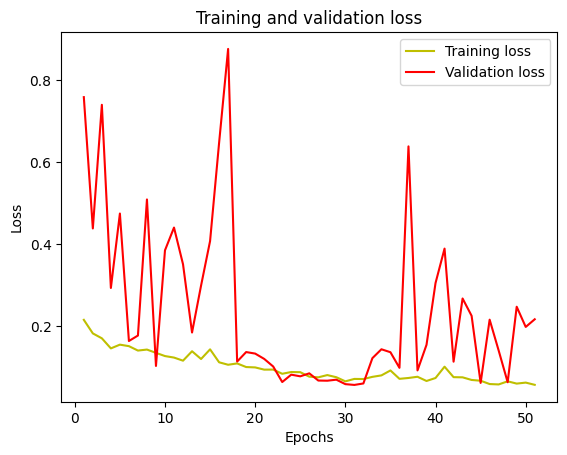

In [11]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

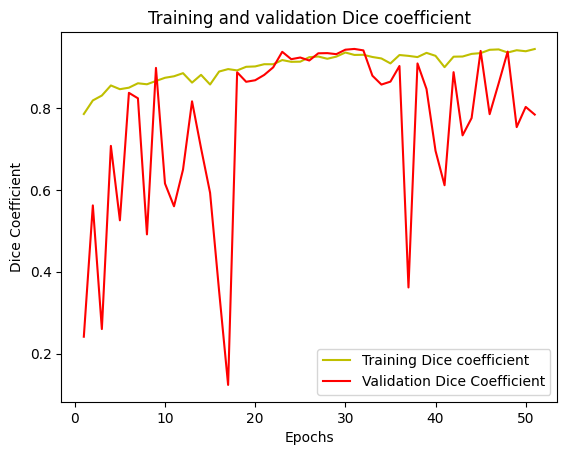

In [12]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

plt.plot(epochs, acc, 'y', label='Training Dice coefficient')
plt.plot(epochs, val_acc, 'r', label='Validation Dice Coefficient')
plt.title('Training and validation Dice coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

In [13]:
print('max training dice: ',max(acc))
print('max validation dice: ',max(val_acc))

max training dice:  0.9439455270767212
max validation dice:  0.9441758990287781


In [14]:
a.load_weights(filepath)

In [15]:
def inf(path,path_m,a):
    test_volume,img_size = parse_image(path)
    test_mask = parse_mask(path_m, img_size)
    test_mask = np.expand_dims(test_mask, axis=0)
    test_mask = np.expand_dims(test_mask, axis=4)
    test_mask = np.where(test_mask>0,1,test_mask)
    test_mask = test_mask.astype(np.uint8)
    depth, height, width = test_volume.shape
    crop_size = (96,96,96)
    # Calculate the number of crops along each axis
    num_crops_depth = (depth) // crop_size[0]
    num_crops_height = (height) // crop_size[1]
    num_crops_width = (width) // crop_size[2]

    # Calculate the amount of padding needed for each dimension
    pad_depth = crop_size[0] - (depth -  num_crops_depth * crop_size[0])
    pad_height = crop_size[1] - (height -  num_crops_height * crop_size[1])
    pad_width = crop_size[2] - (width - num_crops_width * crop_size[2] )
    #print(pad_depth,pad_height,pad_width)
    num_crops_depth = num_crops_depth + 1 if pad_depth > 0 else num_crops_depth
    num_crops_height = num_crops_height + 1 if pad_height > 0 else num_crops_height
    num_crops_width = num_crops_width + 1 if pad_width > 0 else num_crops_width
    #print(num_crops_depth,num_crops_height,num_crops_width)
    # Pad the test volume and test mask to match the crop size
    padded_volume = np.pad(test_volume, ((0, pad_depth), (0, pad_height), (0, pad_width)), mode='constant')
    padded_volume = np.expand_dims(padded_volume, axis=0)
    padded_volume = np.expand_dims(padded_volume, axis=4)
    padded_mask = np.pad(test_mask, ((0,0),(0, pad_depth), (0, pad_height), (0, pad_width),(0,0)), mode='constant')

    pred_mask = np.empty(test_mask.shape,dtype = 'float32')
    pred_mask = np.pad(pred_mask, ((0,0),(0, pad_depth), (0, pad_height), (0, pad_width),(0,0)), mode='constant')

    for d in range(num_crops_depth):
        for h in range(num_crops_height):
            for w in range(num_crops_width):
                # Calculate the starting and ending indices for cropping
                start_depth = d * crop_size[0]
                end_depth = (d + 1) * crop_size[0]
                start_height = h * crop_size[1]
                end_height = (h + 1) * crop_size[1]
                start_width = w * crop_size[2]
                end_width = (w + 1) * crop_size[2]

                # Crop the sub-volumes for the volume and mask
                image = padded_volume[:,start_depth:end_depth, start_height:end_height, start_width:end_width,:]

                mask = a.predict(image)
                pred_mask[:,start_depth:end_depth, start_height:end_height, start_width:end_width,:] = mask

    pred_mask = pred_mask[:,:-pad_depth,:-pad_height,:-pad_width,:]
    return test_mask, pred_mask

In [16]:
tr_dice_9=[]
tr_dice_8=[]
tr_dice_7=[]
tr_dice_6=[]
tr_dice_5=[]
tr_dice_4=[]
tr_dice_3=[]
tr_dice_2=[]
tr_dice_1=[]
tr_dice_05=[]
tr_dice_01=[]
for i in tqdm(range(0,len(testpath))):
    test_mask, pred_mask = inf(testpath[i],testpath_m[i],a)
    y_pred_argmax=np.where(pred_mask>0.9,1,0)
    tr_dice_9.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.8,1,0)
    tr_dice_8.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.7,1,0)
    tr_dice_7.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.6,1,0)
    tr_dice_6.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.5,1,0)
    tr_dice_5.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.4,1,0)
    tr_dice_4.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.3,1,0)
    tr_dice_3.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.2,1,0)
    tr_dice_2.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.1,1,0)
    tr_dice_1.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.05,1,0)
    tr_dice_05.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.01,1,0)
    tr_dice_01.append(compute_dice(y_pred_argmax, test_mask))
print('at 0.9: dice: ',np.mean(tr_dice_9))
print('at 0.8: dice: ',np.mean(tr_dice_8))
print('at 0.7: dice: ',np.mean(tr_dice_7))
print('at 0.6: dice: ',np.mean(tr_dice_6))
print('at 0.5: dice: ',np.mean(tr_dice_5))
print('at 0.4: dice: ',np.mean(tr_dice_4))
print('at 0.3: dice: ',np.mean(tr_dice_3))
print('at 0.2: dice: ',np.mean(tr_dice_2))
print('at 0.1: dice: ',np.mean(tr_dice_1))
print('at 0.05: dice: ',np.mean(tr_dice_05))
print('at 0.01: dice: ',np.mean(tr_dice_01))

  0%|                                                     | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_3300931/172801869.py:72: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im1 = np.asarray(im1).astype(np.bool)
/tmp/ipykernel_3300931/172801869.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im2 = np.asarray(im2).astype(np.bool)
100%|█████████████████

at 0.9: dice:  0.7515640094083323
at 0.8: dice:  0.7525859484422838
at 0.7: dice:  0.7530739037947483
at 0.6: dice:  0.7531480065084424
at 0.5: dice:  0.7532251690949543
at 0.4: dice:  0.7530010940855716
at 0.3: dice:  0.7427021892838832
at 0.2: dice:  0.6833301266298815
at 0.1: dice:  0.6418737317887142
at 0.05: dice:  0.01935336881974436
at 0.01: dice:  0.012601673766656682
